In [29]:
import os
import sys
import pickle

import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# turn off dark mode
plt.style.use('default')

from tqdm import tqdm

In [30]:
class StockReturnsDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame) -> None:
        super().__init__()
        # preprocess dataset
        self.returns = dataset.pct_change(1, fill_method="ffill")[1:]

    def __len__(self):
        return len(self.returns) - 1

    def __getitem__(self, index):
        i, j = self.returns.index[index], self.returns.index[index + 1]
        x = self.returns.loc[i].values
        y = self.returns.loc[j].values

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        return x, y

In [31]:
with open("train_dataset.pkl", "rb") as f:
    train_df = pickle.load(f)
    train_df = train_df['Adj Close'].fillna(method='ffill').dropna(axis=1)
    stocks = train_df.columns

with open("test_dataset.pkl", "rb") as f:
    test_df = pickle.load(f)
    test_df = test_df['Adj Close'].fillna(method='ffill')
    test_df = test_df[stocks]

In [33]:
with open("train_dataset.pkl", "rb") as f:
    train_df = pickle.load(f)
train_df

Adj Close                                                 \
                     A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2018-07-02   59.257793  37.547699  124.741768   44.660526   72.923531   
2018-07-03   59.045719  36.950611  125.028900   43.882687   73.315132   
2018-07-05   59.575920  37.185535  125.816002   44.235817   73.996513   
2018-07-06   60.048294  37.283417  127.029213   44.849010   75.907509   
2018-07-09   60.848412  38.477581  130.529709   45.471756   76.001511   
...                ...        ...         ...         ...         ...   
2023-05-23  128.394821  14.070000  116.367355  171.328644  140.957336   
2023-05-24  120.759392  13.800000  114.822830  171.608261  139.602341   
2023-05-25  119.262253  14.380000  111.225586  172.756714  137.100082   
2023-05-26  120.190483  14.350000  111.753716  175.193420  136.051712   
2023-05-30  117.505615  14.620000  111.803535  177.060898  134.944000   

                                                                       ...  \
                   ABC         ABT       ACGL         ACN        ADBE  ...   
Date                                                                   ...   
2018-07-02   78.981331   55.920242  26.629999  151.432709  243.259995  ...   
2018-07-03   79.865852   55.746063  26.760000  151.534744  242.009995  ...   
2018-07-05   80.344978   56.222771  26.930000  152.889236  244.179993  ...   
2018-07-06   81.054459   56.983654  27.280001  152.620193  248.190002  ...   
2018-07-09   81.312439   57.240330  27.889999  154.123108  249.770004  ...   
...                ...         ...        ...         ...         ...  ...   
2023-05-23  170.812729  105.235298  73.169998  287.058197  370.420013  ...   
2023-05-24  170.613266  103.543419  71.769997  285.782837  365.760010  ...   
2023-05-25  169.725586  101.652481  72.379997  290.704956  392.059998  ...   
2023-05-26  167.970184  102.379005  71.000000  302.502136  415.390015  ...   
2023-05-30  165.576447  101.224533  71.199997  307.314667  417.209991  ...   

             Volume                                                          \
               WYNN      XEL       XOM     XRAY       XYL      YUM      ZBH   
Date                                                                          
2018-07-02  6755000  2826200   9998300  1911100   1005100  1599100   792997   
2018-07-03  2227700  1811300   7197300  1435600    755800   968300   534776   
2018-07-05  2626100  2574300   9035700  3017000   1860300  1431000   708949   
2018-07-06  2048800  2193800   7637100  1765200   1219800  1392600   958209   
2018-07-09  4568900  4289700   7158600  2151700   1038700  1598400   595340   
...             ...      ...       ...      ...       ...      ...      ...   
2023-05-23  3877500  3966300  14394400  2093900  11602900  1828300  1153700   
2023-05-24  2342700  3562000  16340300  1555000   4165600  1352200  1169000   
2023-05-25  1834800  3706100  14316500  1440800  20241700  2364400  1390400   
2023-05-26  1808200  2954000  12370300  1655800   4632700  2145000  1354300   
2023-05-30  3623400  2339800  11938000  1788800   3668600  1843100  1234200   

                                      
              ZBRA     ZION      ZTS  
Date                                  
2018-07-02  594000  2197500  1759000  
2018-07-03  324200   886700  1283500  
2018-07-05  448300  1625200  2474600  
2018-07-06  150500  1476500  2073600  
2018-07-09  286300  1937700  1836800  
...            ...      ...      ...  
2023-05-23  359600  9434400  2301700  
2023-05-24  467500  5329200  2437900  
2023-05-25  356700  5220900  3626300  
2023-05-26  243500  3016400  1909400  
2023-05-30  271000  4164100  2185000  

[1236 rows x 3018 columns]

In [4]:
train_dataset = StockReturnsDataset(train_df)
test_dataset = StockReturnsDataset(test_df)

print("train dataset length", len(train_dataset))
print("test dataset length", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

x,y = next(iter(train_loader))
x.shape, y.shape

train dataset length 1234
test dataset length 19


(torch.Size([16, 493]), torch.Size([16, 493]))

In [5]:
class RRNet(torch.nn.Module):
    def __init__(self, dim=503, depth=5, activation=torch.nn.ReLU, dropout=0.3) -> None:
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.activation = activation
        self.dropout = dropout

        _mlps = []
        for _ in range(depth):
            _mlps.append(torch.nn.Linear(dim, dim))
            _mlps.append(activation())
            _mlps.append(torch.nn.Dropout(dropout))
        _mlps.append(torch.nn.Linear(dim, dim)) # last layer without activation
        self.mlps = torch.nn.Sequential(*_mlps)

    def forward(self, x):
        # forward pass with skip connection
        return x + self.mlps(x)

In [6]:
def num_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

In [26]:
net = RRNet(len(train_df.columns), 10, torch.nn.ReLU, 0.6)
print("number of parameters:", num_params(net))
net

number of parameters: 2678962


RRNet(
  (mlps): Sequential(
    (0): Linear(in_features=493, out_features=493, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=493, out_features=493, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=493, out_features=493, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=493, out_features=493, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.6, inplace=False)
    (12): Linear(in_features=493, out_features=493, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.6, inplace=False)
    (15): Linear(in_features=493, out_features=493, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.6, inplace=False)
    (18): Linear(in_features=493, out_features=493, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.6, inplace=False)
    (21): Linear(in_features=493, out_features=493, bias=True)
    (22): ReLU()
    (23): Dropout(p=0.6, inplace=False)
    (24): Linear(in_f

In [23]:
def test_model(model, loader):
    """
    using the network predicted returns to evaluate the model
    """
    L = []
    with torch.no_grad():
        for x,y in loader:
            y_pred = model(x)
            loss = torch.nn.functional.mse_loss(y_pred, y)
            L.append(loss.item())
    return np.nanmean(L)

In [21]:
len(train_loader)

78

In [27]:
# training loop

EPOCHS = 5

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = "cpu"

net.train()

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    print(f"epoch {epoch + 1}/{EPOCHS}")
    with tqdm(total=len(train_loader)) as progress:
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            # forward
            output = net(X)
            loss = loss_fn(output, y)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            progress.set_postfix(loss=running_loss / (i + 1))
            progress.update()

    train_losses.append(running_loss / len(train_loader))

    # evaluate on test set
    test_losses.append(test_model(net, test_loader))


epoch 1/5


  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [00:03<00:00, 19.58it/s, loss=0.00125]


epoch 2/5


100%|██████████| 78/78 [00:03<00:00, 22.01it/s, loss=0.00116]


epoch 3/5


100%|██████████| 78/78 [00:03<00:00, 23.40it/s, loss=0.0012] 


epoch 4/5


100%|██████████| 78/78 [00:03<00:00, 22.71it/s, loss=0.00114] 


epoch 5/5


100%|██████████| 78/78 [00:03<00:00, 23.53it/s, loss=0.00112] 


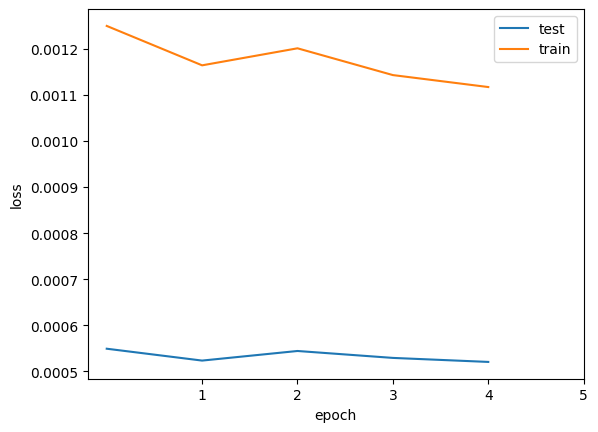

In [28]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.xticks(np.arange(1, EPOCHS+1, 1))
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()